In [ ]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
import os
from skimage import io, img_as_float
import matplotlib.pyplot as plt

In [74]:
SENTENCE_LIST = [
    "confidential data only", "this is a sample image", "hello world!",
    "important notice", "system warning message", "demo version only",
    "approved for internal use", "this is a draft", "test image content",
    "image for analysis", "data under review", "confidential report",
    "access restricted", "secure file only", "for authorized personnel only",
    "internal use only", "do not distribute", "for your eyes only",
    "private and confidential", "not for public release", "top secret",
    "classified information", "company confidential", "proprietary data",
    "sensitive information", "restricted access", "internal document",
]

def does_overlap(box1, box2):
    # box: (x1, y1, x2, y2)
    return not (box1[2] < box2[0] or box1[0] > box2[2] or
                box1[3] < box2[1] or box1[1] > box2[3])

def add_text_overlay(img_path, max_sentences=7, font_rel_range=(0.05,0.1), max_attempts=100):

    img = img_as_float(io.imread(img_path))
    new_seed = int(img_path.split("/")[-1].split(".")[0].split("_")[-1])
    print(f"New seed: {new_seed}") 
    random.seed(new_seed)
    img_pil = Image.fromarray((img * 255).astype(np.uint8)).convert("L")
    draw = ImageDraw.Draw(img_pil)
    width, height = img_pil.size
    used_boxes = []

    # Convert relative font size range to absolute (pixels)
    min_font = int(font_rel_range[0] * height)
    max_font = int(font_rel_range[1] * height)

    for _ in range(random.randint(3, max_sentences)):
        sentence = random.choice(SENTENCE_LIST)
        font_size = random.randint(min_font, max_font)
        try:
            font = ImageFont.truetype("arial.ttf", font_size)
        except:
            font = ImageFont.load_default()
        print(f"Font size: {font_size}")
        print(f"Sentence: {sentence}")
        # Measure text
        try:
            bbox = draw.textbbox((0, 0), sentence, font=font)
            text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
        except AttributeError:
            text_width, text_height = draw.textsize(sentence, font=font)

        if text_width > width or text_height > height:
            continue  # Skip if it just can't fit

        placed = False
        for _ in range(max_attempts):
            x = random.randint(0, max(0, width - text_width))
            y = random.randint(0, max(0, height - text_height))
            new_box = (x, y, x + text_width, y + text_height)

            if not any(does_overlap(new_box, b) for b in used_boxes):
                draw.text((x, y), sentence, fill=255, font=font)
                used_boxes.append(new_box)
                placed = True
                break

        if not placed:
            print(f"Warning: Couldn't place sentence '{sentence}' without overlap.")

    return np.array(img_pil) / 255.0

New seed: 7
Font size: 18
Sentence: system warning message
Font size: 25
Sentence: hello world!
Font size: 12
Sentence: private and confidential
Font size: 13
Sentence: this is a sample image
Font size: 12
Sentence: secure file only


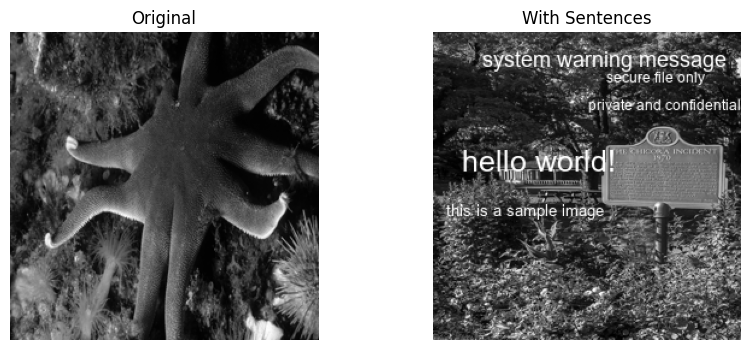

In [ ]:
# Example usage
img_pth = "../medical-images/image.jpg"
corrupted = add_text_overlay(img_pth)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(corrupted, cmap='gray'); plt.title("With Sentences"); plt.axis('off')
plt.show()
